# Density at 150 pc (NFW) - pericenter relation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import os

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import log_model, run_best_fit_for_sim, run_best_fit_for_sim_with_mcmc

plt.style.use("pltstyle.mplstyle")
cmap = matplotlib.cm.RdYlBu

## Observational data

In [2]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

Vmax = Kaplinghat_data[:,2]
le_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,3]
he_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,4]
NFW_Vmax = 10**Vmax[::2] # Only NFW fit data; [km/s] units
le_NFW_Vmax = NFW_Vmax - 10**le_Vmax[::2] # Only NFW fit data; [km/s] units
he_NFW_Vmax = 10**he_Vmax[::2] - NFW_Vmax # Only NFW fit data; [km/s] units

Rmax = Kaplinghat_data[:,5]
le_Rmax = Kaplinghat_data[:,6] + Kaplinghat_data[:,5]
he_Rmax = Kaplinghat_data[:,7] + Kaplinghat_data[:,5]
NFW_Rmax = 10**Rmax[::2] # Only NFW fit data; [kpc] units
le_NFW_Rmax = NFW_Rmax - 10**le_Rmax[::2]  # Only NFW fit data; [kpc] units
he_NFW_Rmax = 10**he_Rmax[::2] - NFW_Rmax  # Only NFW fit data; [kpc] units
he_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2
le_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2

num_satellites = len(NFW_Rmax)
M200_K19 = np.zeros((3,num_satellites))
R200_K19 = np.zeros((3,num_satellites))

rho_s = np.zeros(num_satellites)
r_s = np.zeros(num_satellites)
r_range = np.arange(-4, 4, 0.01) # Some radial range
r_range = 10**r_range # to kpc

for i in range(num_satellites):
    rho_s[i] = calculate_rho_s(NFW_Vmax[i], NFW_Rmax[i])
    r_s[i] = calculate_r_s(NFW_Rmax[i])
    rho = NFW_profile(r_range, rho_s[i], r_s[i])
    mass_within_r = mass(rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[0, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[0, i] = calculate_M200(R200_K19[0, i])

    ## Dealing with error propagration..
    low_error_rho = rho - calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], le_NFW_Vmax[i], le_NFW_Rmax[i])
    mass_within_r = mass(low_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[1, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[1, i] = M200_K19[0, i] - calculate_M200(R200_K19[1, i])

    high_error_rho = rho + calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], he_NFW_Vmax[i], he_NFW_Rmax[i])
    mass_within_r = mass(high_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[2, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[2, i] = calculate_M200(R200_K19[2, i]) - M200_K19[0, i]

In [3]:
# We remove CVnI
num_satellites -= 1
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

(10.0, 500.0, 5000000.0, 1000000000.0)

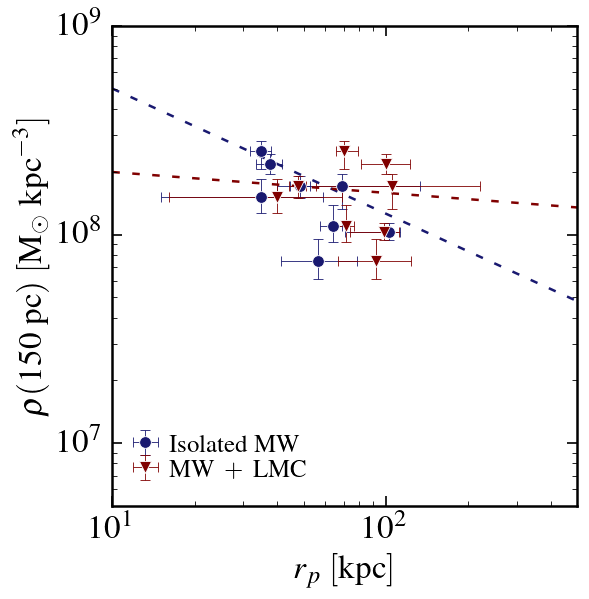

In [4]:
def plot_obs(axs):

    # Data points                 
    p1 = axs.errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='o', markersize=7, markeredgecolor="white", ls='none', lw=0.5, c='midnightblue',label=r'$\mathrm{Isolated\ MW}$')
    p2 = axs.errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
            marker='v', markersize=7, markeredgecolor="white", ls='none', lw=0.5, c='maroon',label=r'$\mathrm{MW\ +\ LMC}$')

    # Include the fit from Cardona+ 2023
    xrange = np.arange(1, 3.2, 0.2)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, 2.3, -0.6), '--', lw=1.5, color=p1[0].get_color())
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, 1.4, -0.1), '--', lw=1.5, color=p2[0].get_color())
    
    axs.legend(loc=[0.03, 0.03], labelspacing=0.1, handlelength=0.7, handletextpad=0.6, frameon=False, fontsize=15, ncol=1, numpoints=1)
    axs.set_yscale('log')
    axs.set_xscale('log')
    
    
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
plot_obs(axs)
axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
axs.axis([10, 500, 5e6, 1e9])

## Simulations analysis

In [5]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

### Fit all in each box

100%|██████████| 2000/2000 [00:06<00:00, 293.15it/s]


1.319284195815682 -0.08462196690809137


100%|██████████| 2000/2000 [00:06<00:00, 295.32it/s]


1.3276613892193763 -0.12681416775715887


100%|██████████| 2000/2000 [00:06<00:00, 288.20it/s]


1.3515389467580576 -0.14143643544795026


100%|██████████| 2000/2000 [00:06<00:00, 296.18it/s]


1.9077165156454232 -0.42769461276497045


100%|██████████| 2000/2000 [00:06<00:00, 289.15it/s]


1.8942041337274218 -0.3765621349855791


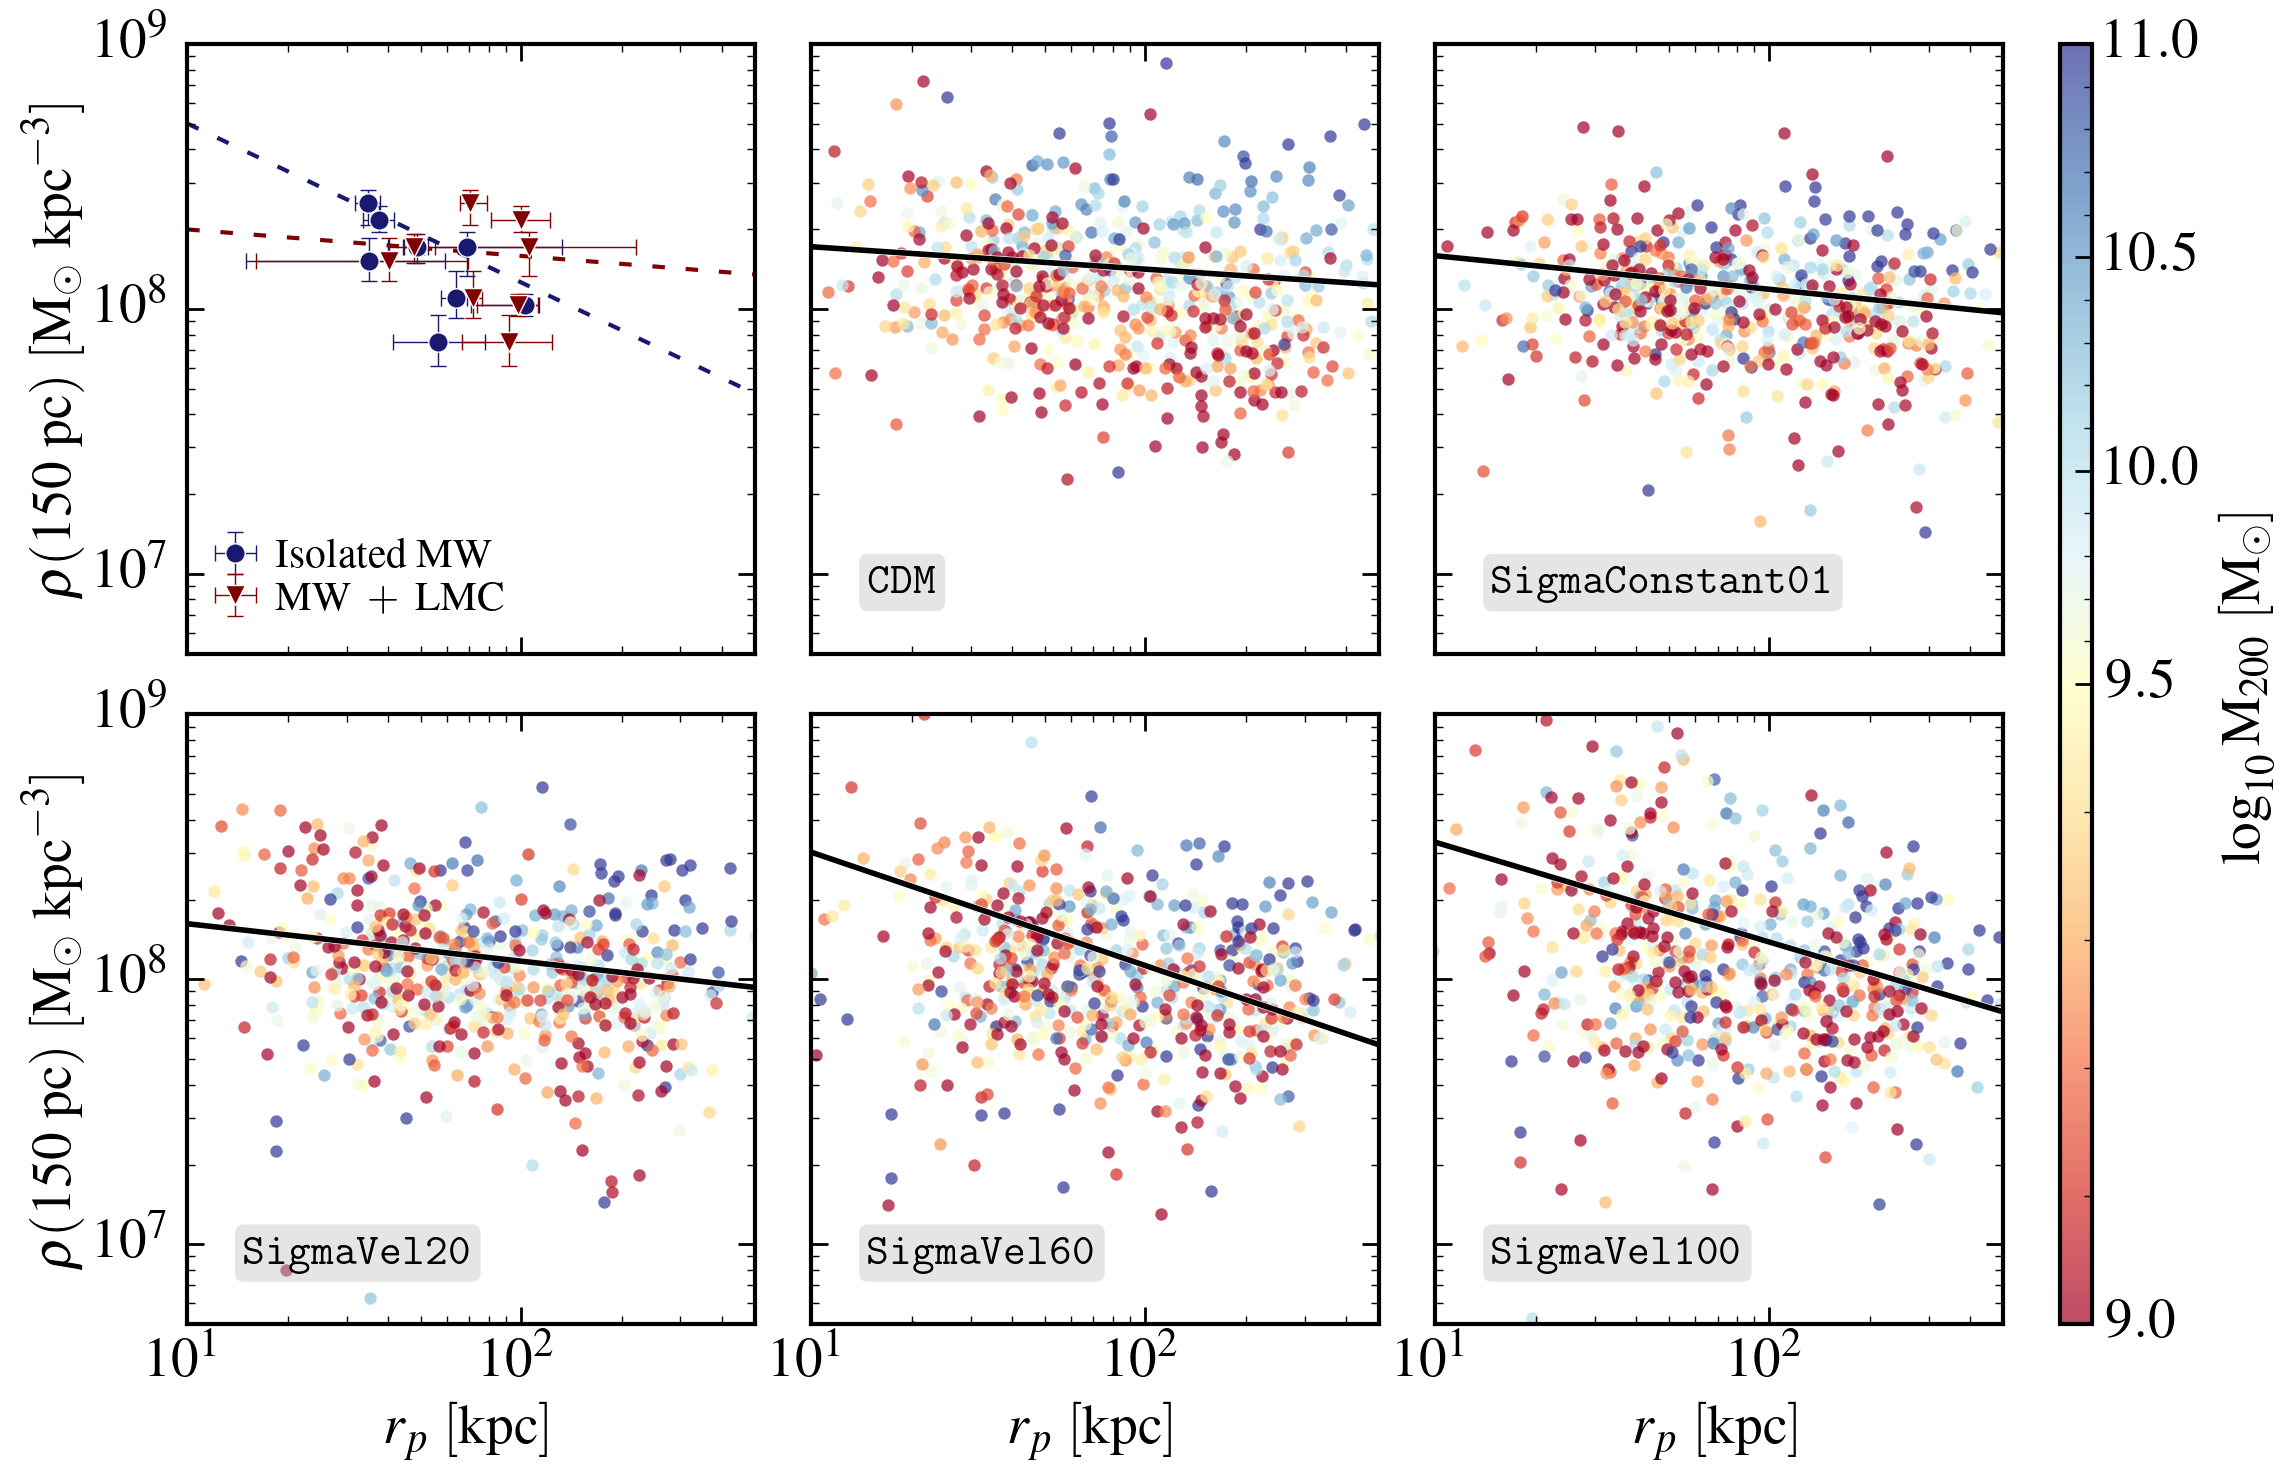

In [6]:
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]

    x = []
    y = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get('subhalo_of') is not None:    
            data_subhalo = file[f'{idx}']
            nfw_fit = data_subhalo['halo_data']['nfw_fit']
            r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
            rho_s = 10**log10_rho_s
            sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
            rho = NFW_profile(r_range, rho_s, r_s)
            mass_within_r = mass(rho, r_range)
            rho_within_r = rho_mean(mass_within_r, r_range)
            R200 = calculate_R200(rho_within_r, r_range)
            M200 = calculate_M200(R200)
            r_p = data_subhalo['tree_data']['pericenter'][1]
            rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
            
            im = axs.scatter(r_p, rho_150, c=np.log10(M200), cmap=cmap, marker='o', 
                             lw=0, norm=normalize, alpha=0.7)

            # Let's append for this sim:
            x = np.append(x, r_p)
            y = np.append(y, rho_150)

    # Some values for rho_150 do not look good, let's clean..
    clean = np.where((y>=1e6) & (y<=1e10))[0]
    y = y[clean]
    x = x[clean]

    samples_Simulation = run_best_fit_for_sim_with_mcmc(x, y)

    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    q = np.median(samples_Simulation[:, 0])
    m = np.median(samples_Simulation[:, 1])
    print(q, m)
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], samples_Simulation[:, 0], samples_Simulation[:, 1]), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], samples_Simulation[:, 0], samples_Simulation[:, 1]), 84)
   
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange,  q, m), '-', lw=2., color='black')
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.1, 0.1,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i==3-1):
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()


####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{200}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 


plt.savefig('figures/Density_pericenter_fit_all.png', dpi=300, transparent=True)
plt.show()



### Fit each MW system in each box

In [7]:
MAX_SATELLITES = 8

filename = f"./outputs/fit_NFW_{MAX_SATELLITES}.npy" if MAX_SATELLITES is not None else "fit_NFW.npy"

if os.path.isfile(filename):
    run_fit = False
    q_save, m_save = np.load(filename, allow_pickle=True)
else:
    run_fit = True
    q_save, m_save = [], []
    
print(run_fit)

False


Total
1.426972891821427 -0.12627328915853048
Total
1.0657758557644068 0.021401462047296357
Total
1.2275187189468295 -0.0366117977285829
Total
1.228116087340068 -0.09936342882602722
Total
1.3494776754160855 -0.14083077915496423


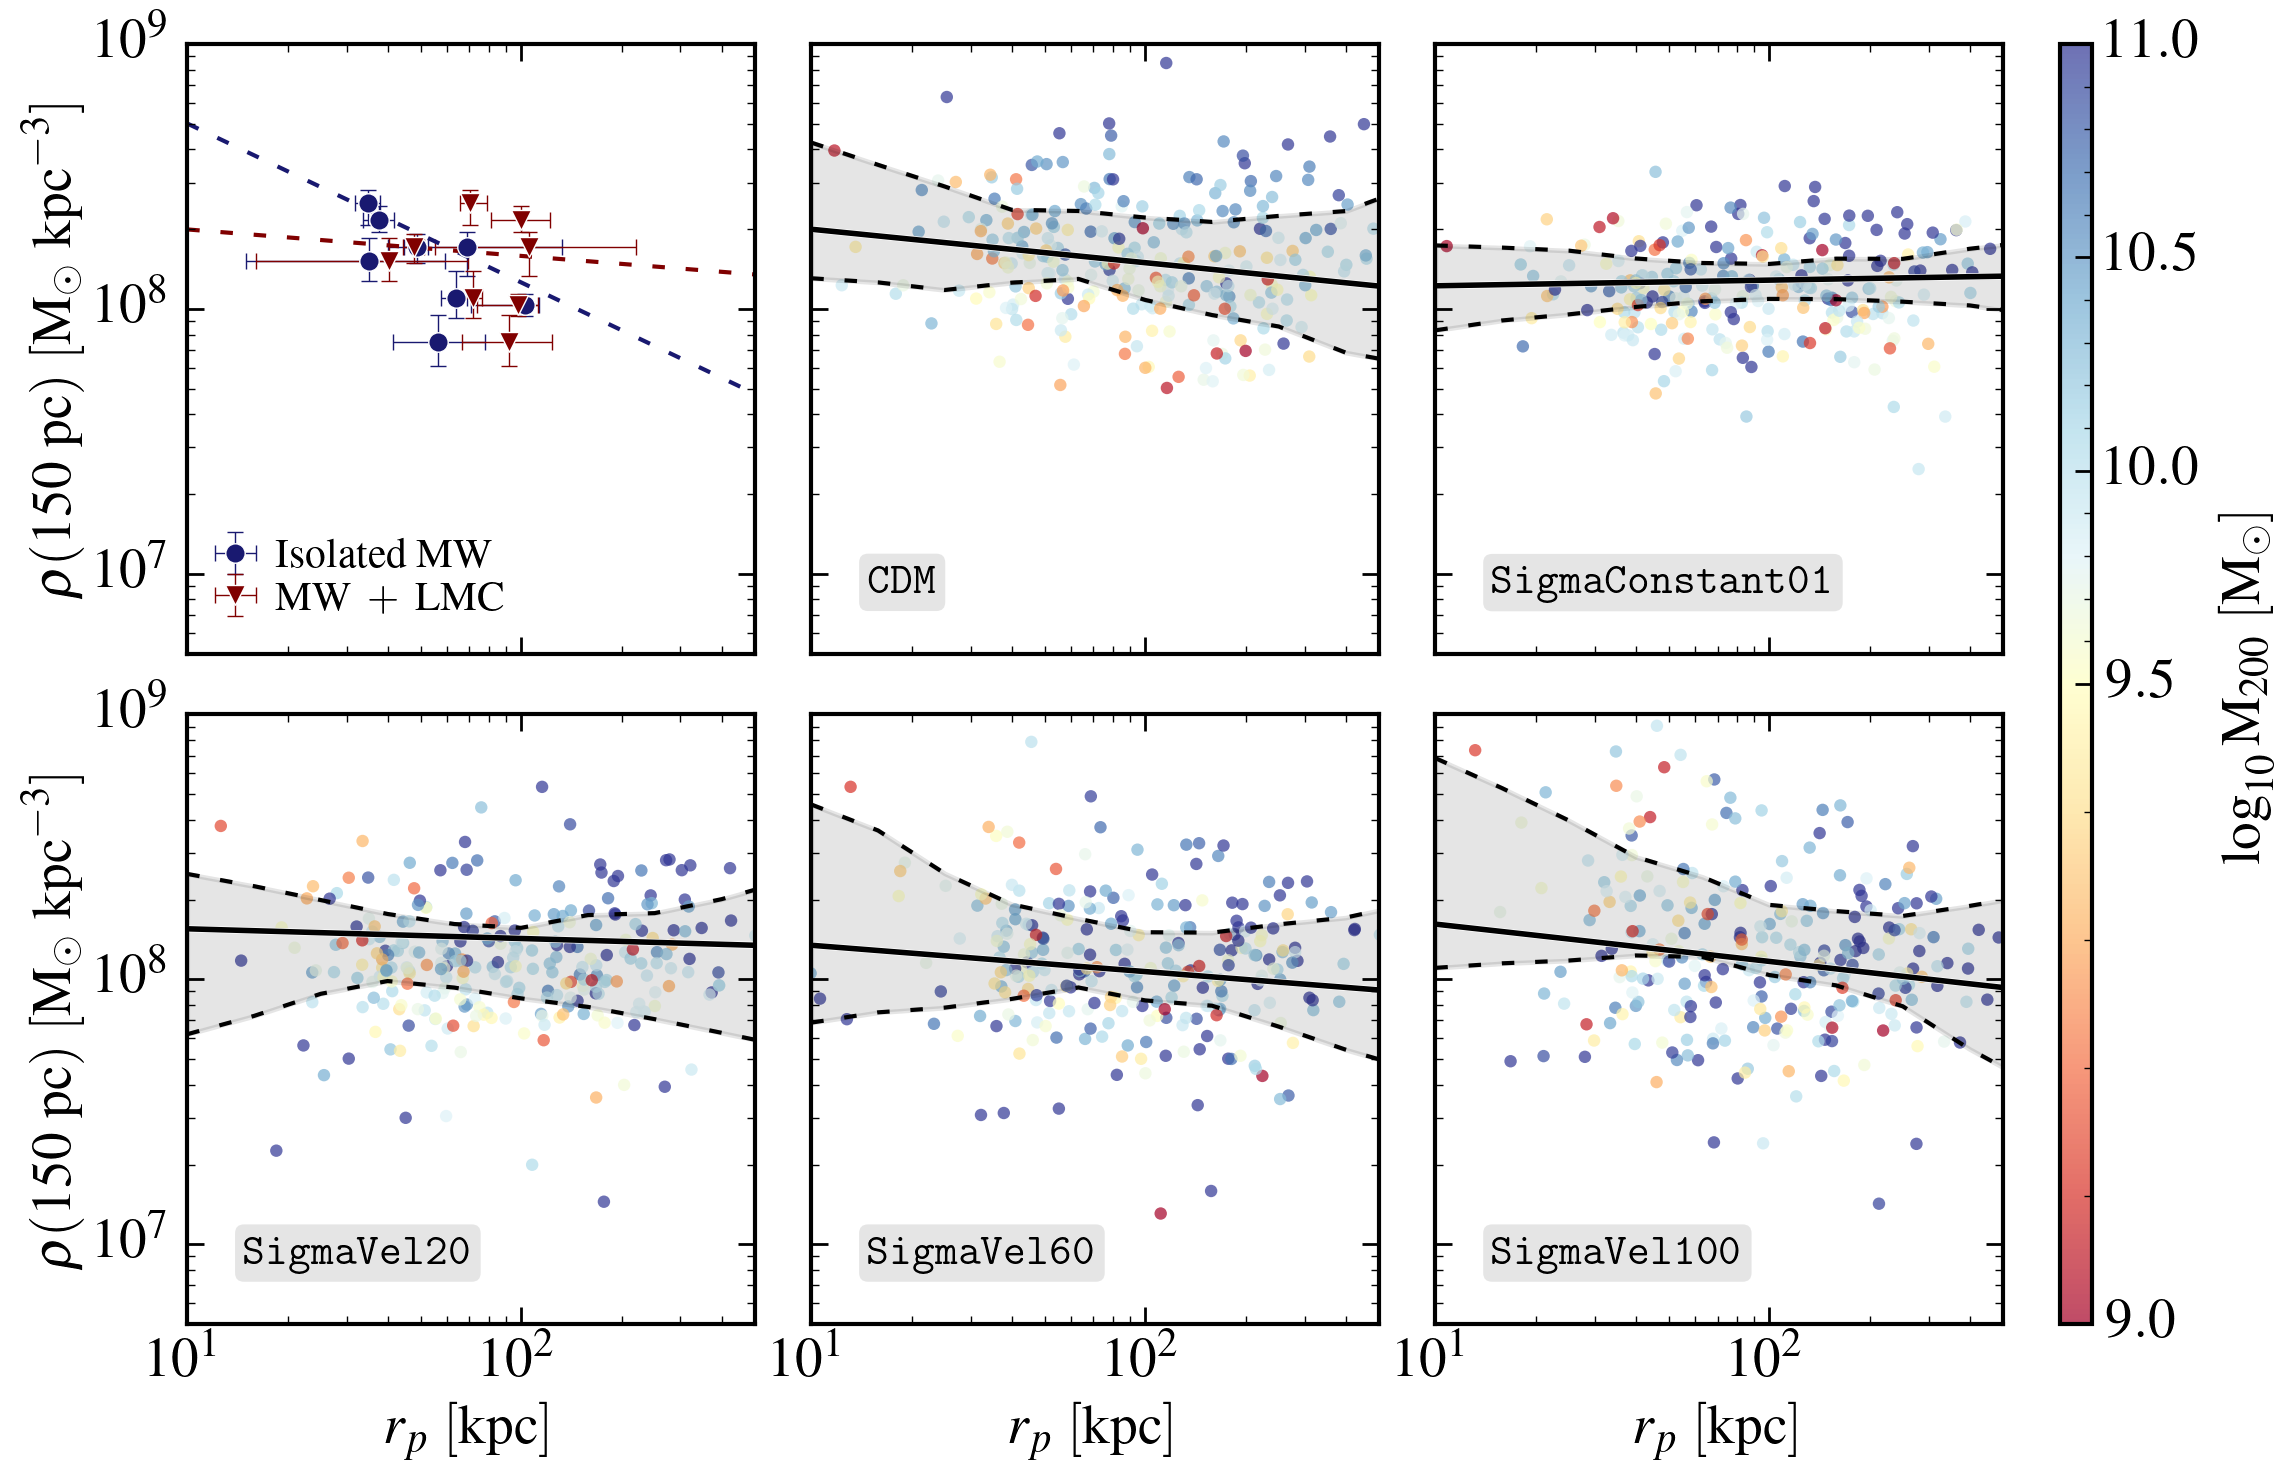

In [8]:
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]

    qs = []
    ms = []
    
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                rho = NFW_profile(r_range, rho_s, r_s)
                mass_within_r = mass(rho, r_range)
                rho_within_r = rho_mean(mass_within_r, r_range)
                R200 = calculate_R200(rho_within_r, r_range)
                _M200 = calculate_M200(R200)
                M200 = np.append(M200, _M200)

            im = axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='o', 
                             lw=0, norm=normalize, alpha=0.7)

            # Fit
            if run_fit:
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                qs = np.append(qs, _q)
                ms = np.append(ms, _m)
                print(_q, _m)
        
    if run_fit:
        q_save.append(qs)
        m_save.append(ms)
        print(len(q_save))
    else:
        qs = q_save[i]
        ms = m_save[i]
        
    print("Total")
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    q = np.median(qs)
    m = np.median(ms)
    print(q, m)
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], qs, ms), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], qs, ms), 84)
    
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange,  q, m), '-', lw=2., color='black')
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.1, 0.1,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i==3-1):
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()
    
# Save fit
if run_fit:
    q_save = np.array(q_save, dtype=object)
    m_save = np.array(m_save, dtype=object)
    np.save(filename, (q_save, m_save))
        
####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{200}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 

plt.savefig(f'figures/Density_pericenter_fit_system_mcmc_{MAX_SATELLITES}.png', dpi=300, transparent=True)
plt.show()

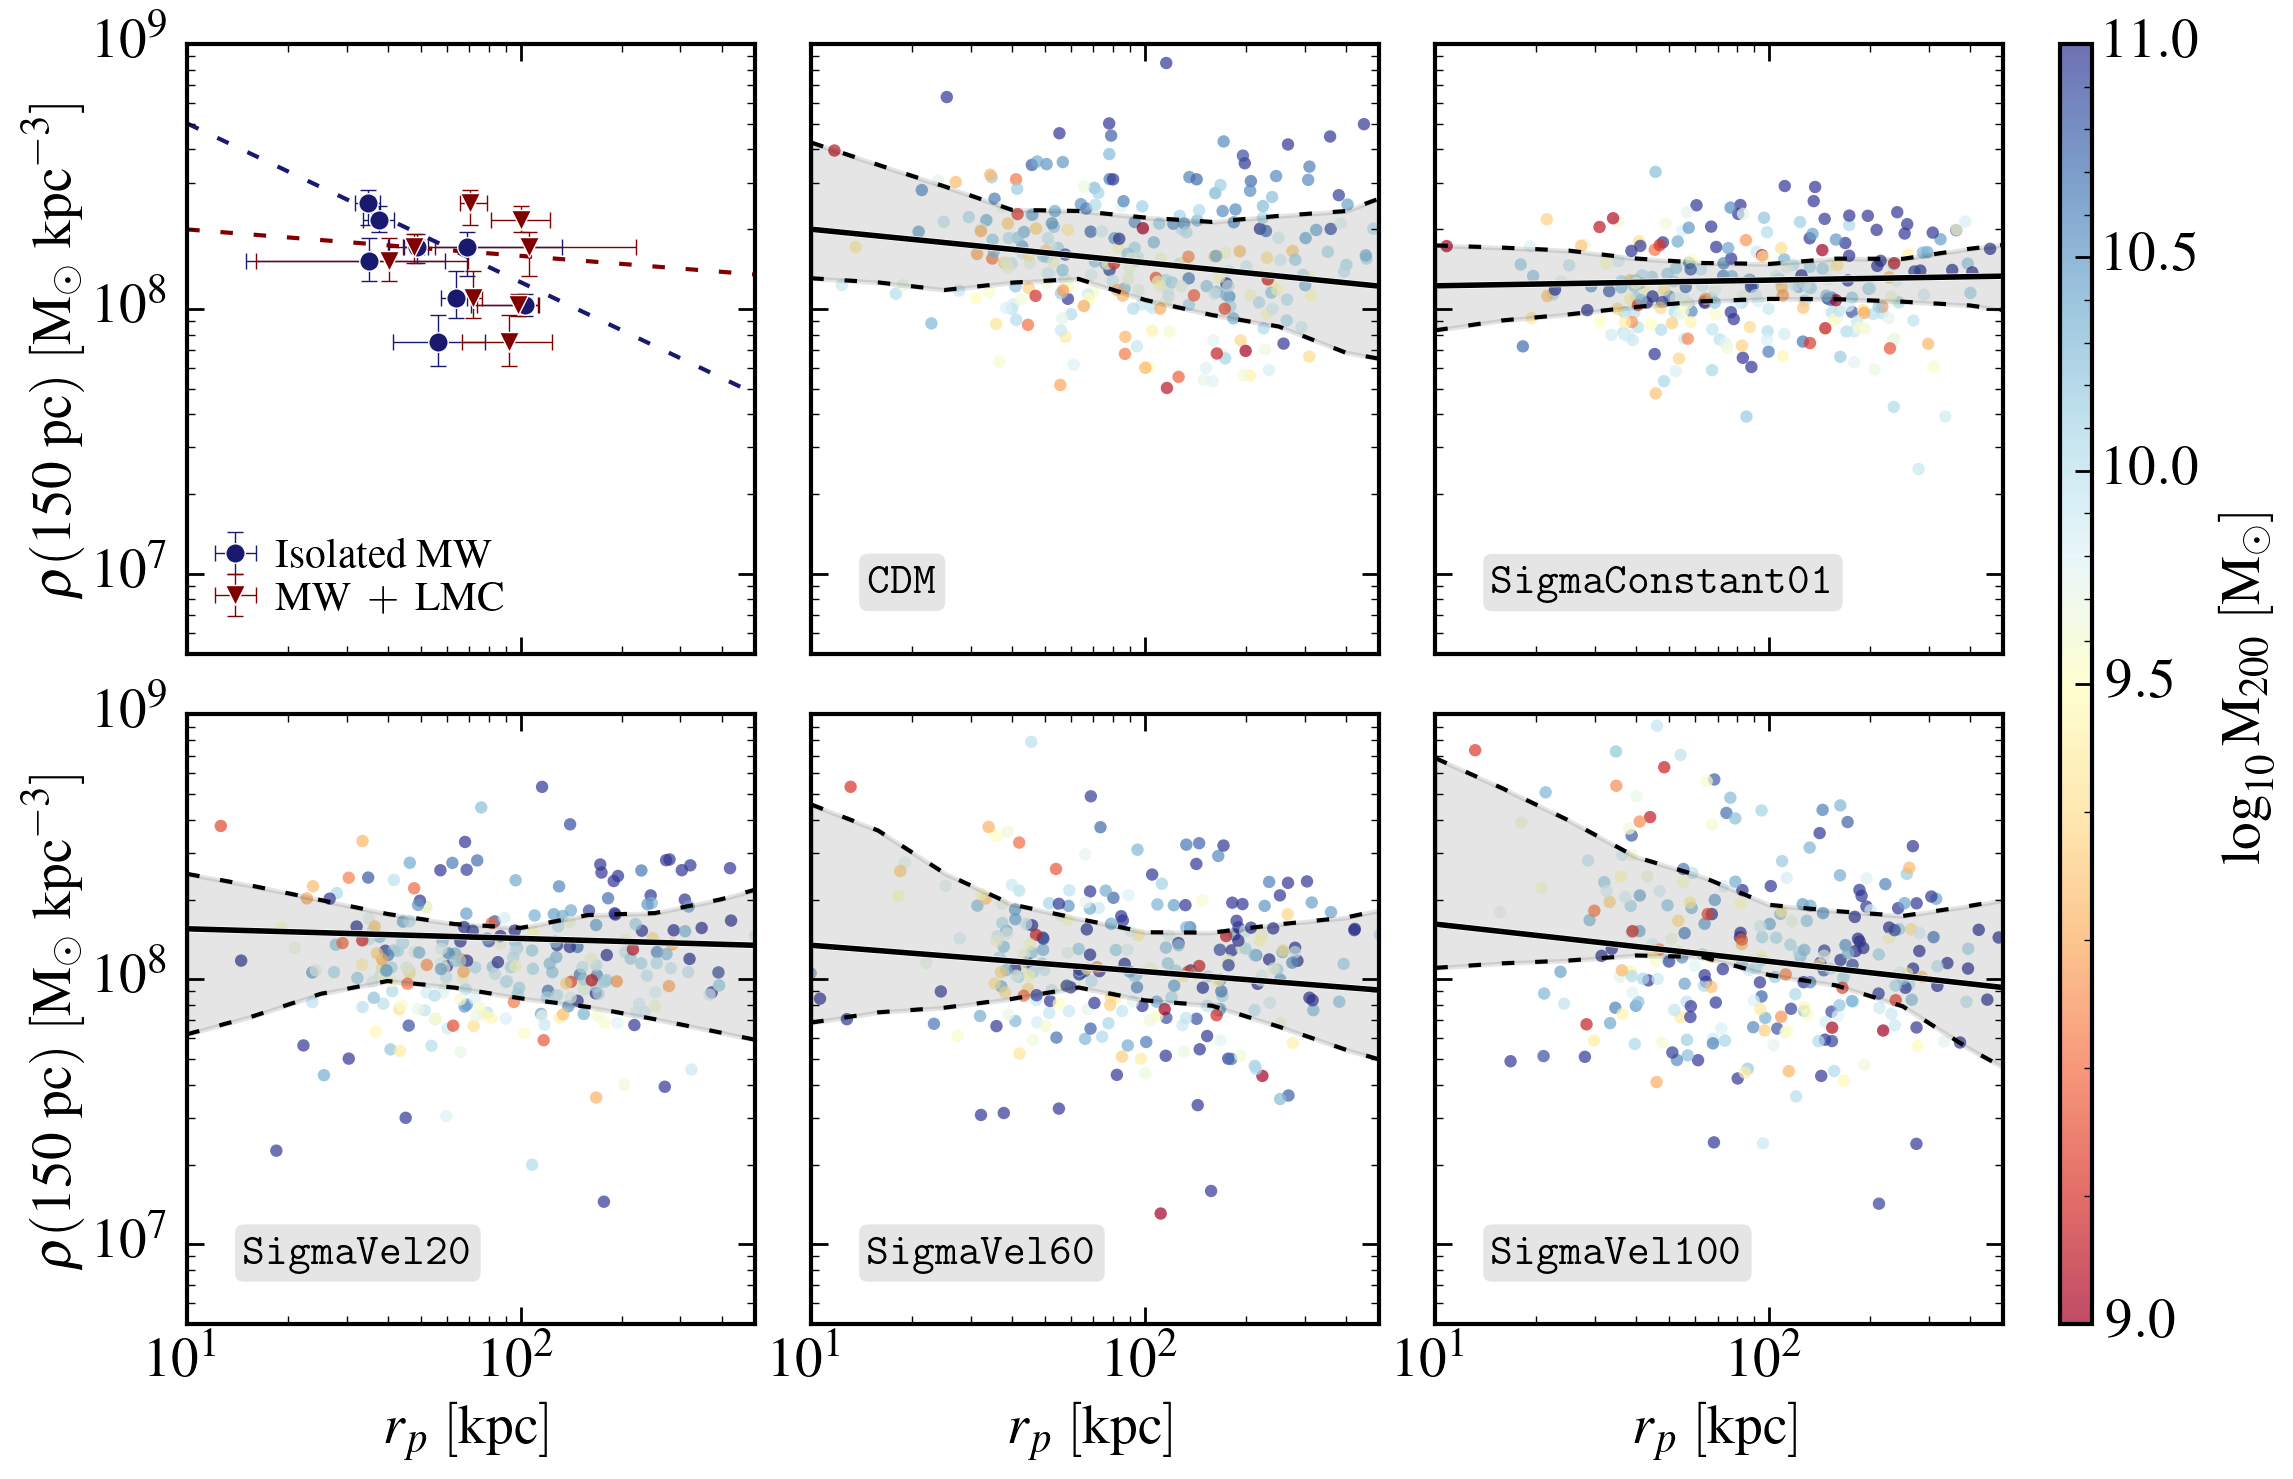

In [9]:
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten() 

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]
        
    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                rho = NFW_profile(r_range, rho_s, r_s)
                mass_within_r = mass(rho, r_range)
                rho_within_r = rho_mean(mass_within_r, r_range)
                R200 = calculate_R200(rho_within_r, r_range)
                _M200 = calculate_M200(R200)
                M200 = np.append(M200, _M200)

            im = axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='o', 
                             lw=0, norm=normalize, alpha=0.7)

            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)

    
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 84)

    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=2., color='black')
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.1, 0.1,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if i==3-1:
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()

####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{200}}$ $\mathrm{[M_\odot]}$',
                     aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 

####
plt.savefig(f'figures/Density_pericenter_fit_system_best_{MAX_SATELLITES}.png',dpi=300, transparent=True)
plt.show()


### With m_peak

In [10]:
MAX_SATELLITES = 8

filename = f"./outputs/fit_NFW_{MAX_SATELLITES}.npy" if MAX_SATELLITES is not None else "fit_NFW.npy"

if os.path.isfile(filename):
    run_fit = False
    q_save, m_save = np.load(filename, allow_pickle=True)
else:
    run_fit = True
    q_save, m_save = [], []
    
print(run_fit)

False


Total
1.426972891821427 -0.12627328915853048
Total
1.0657758557644068 0.021401462047296357
Total
1.2275187189468295 -0.0366117977285829
Total
1.228116087340068 -0.09936342882602722
Total
1.3494776754160855 -0.14083077915496423


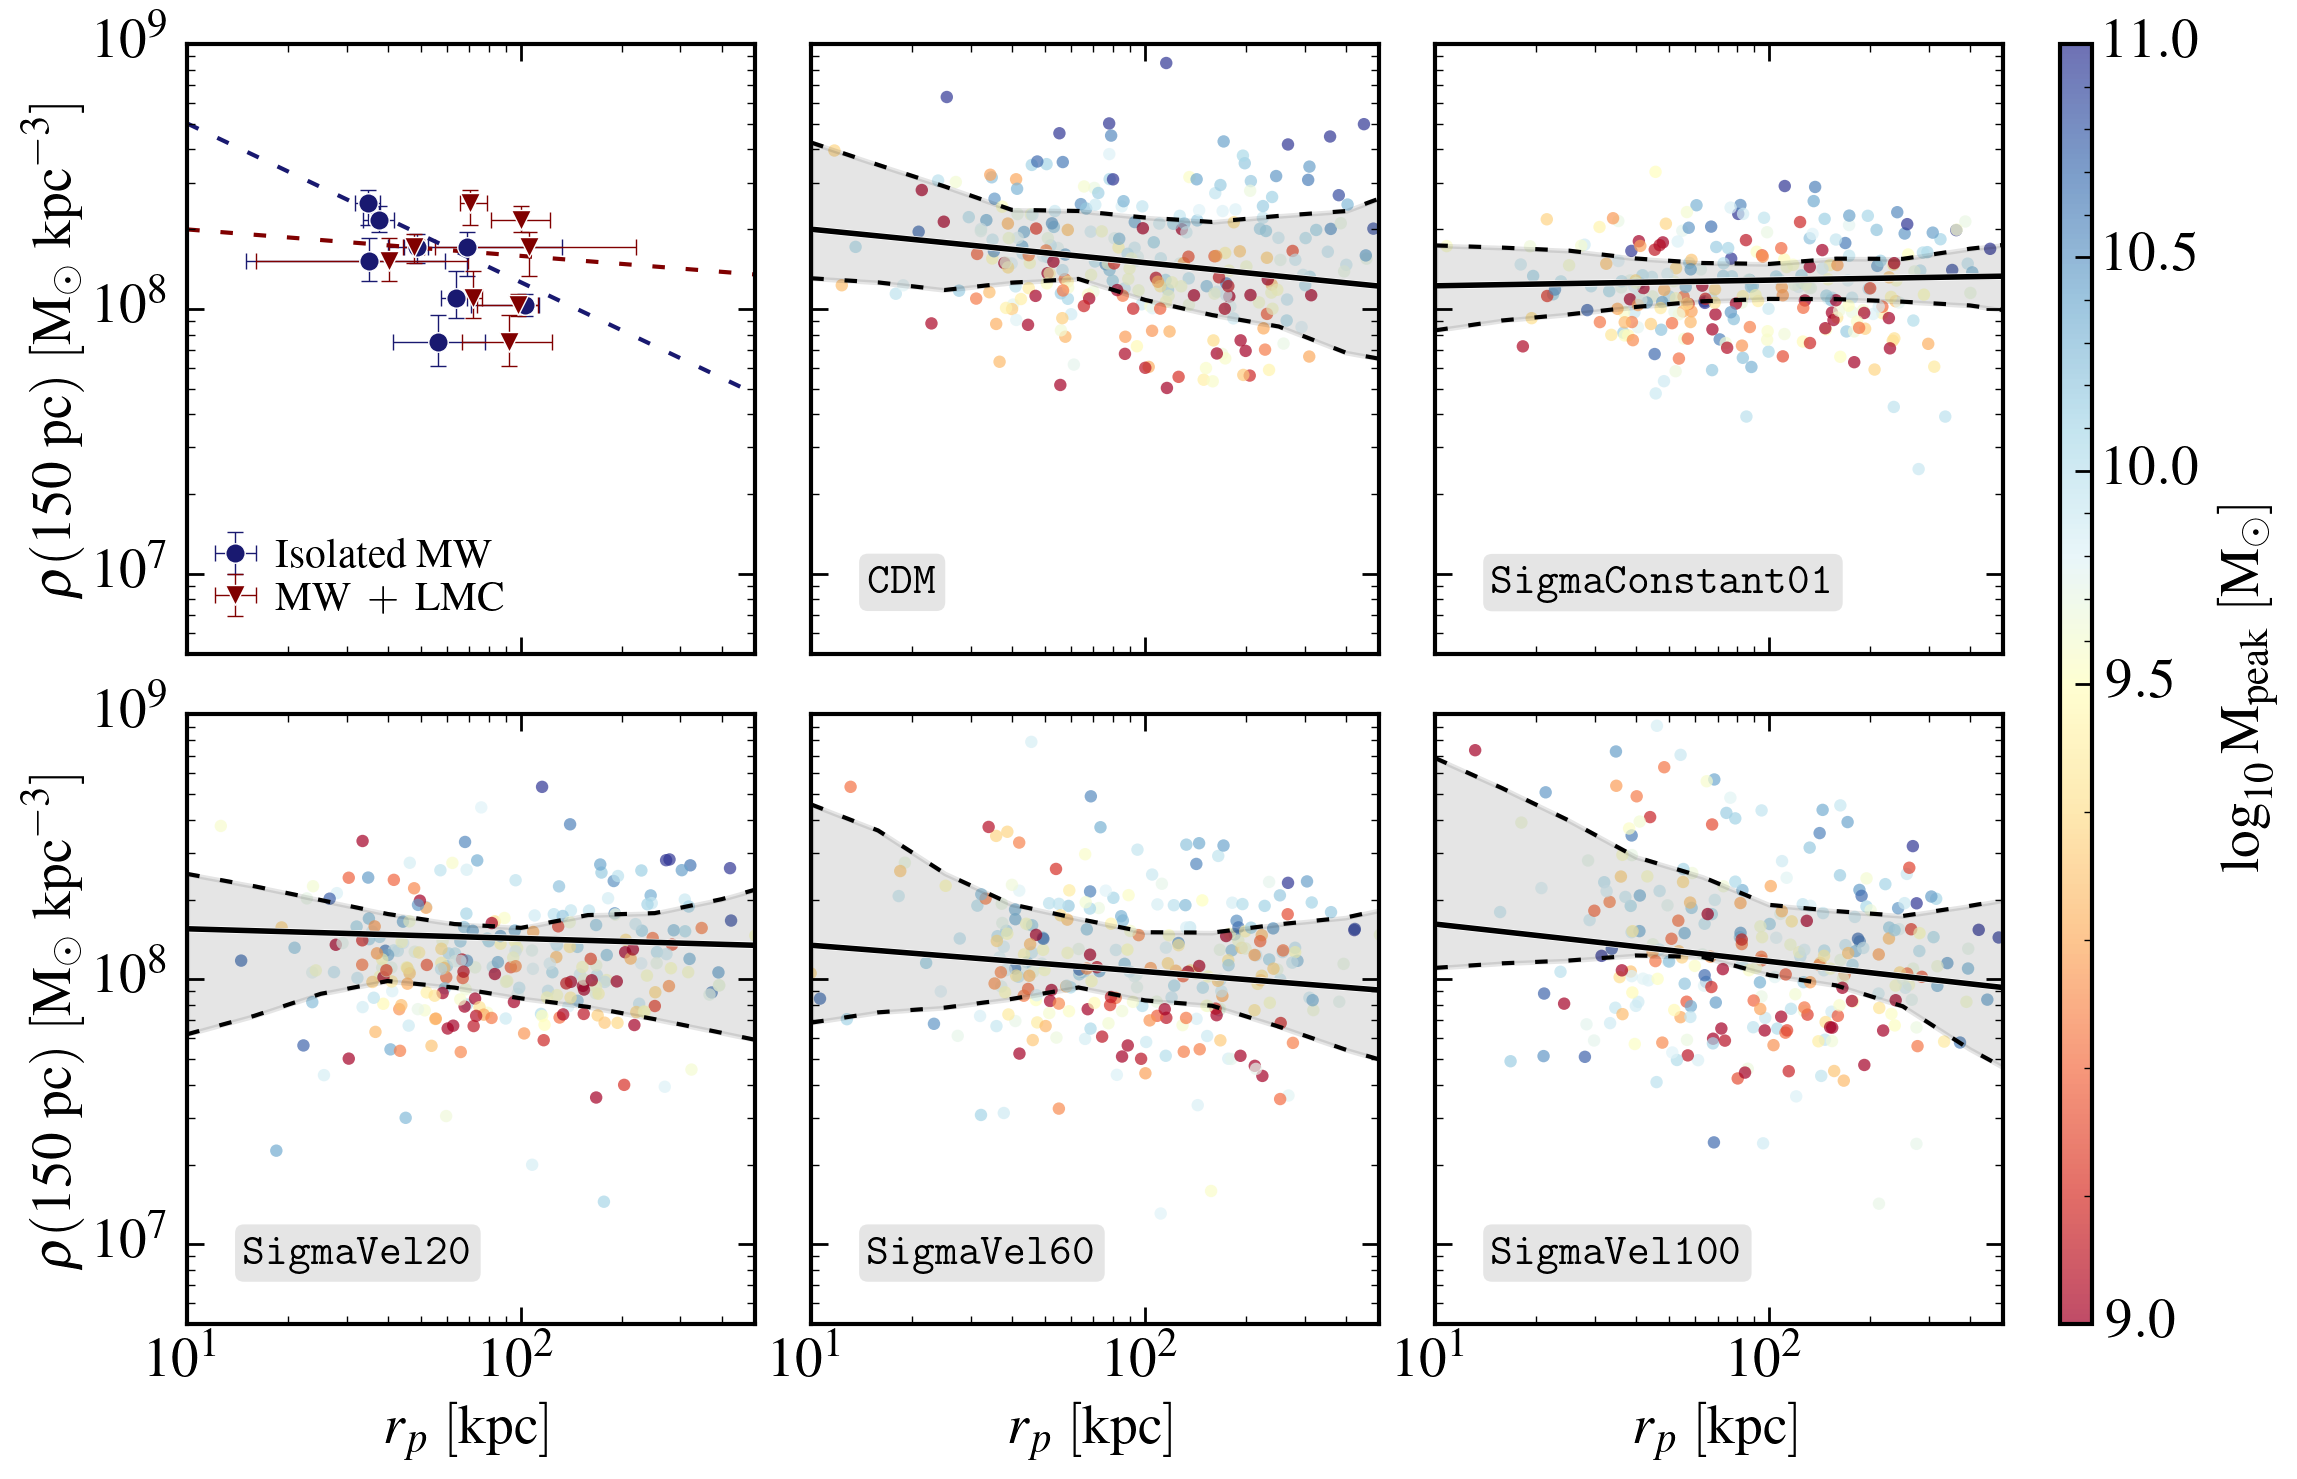

In [11]:
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]

    qs = []
    ms = []
    
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                # sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                # rho = NFW_profile(r_range, rho_s, r_s)
                # mass_within_r = mass(rho, r_range)
                # rho_within_r = rho_mean(mass_within_r, r_range)
                # R200 = calculate_R200(rho_within_r, r_range)
                # _M200 = calculate_M200(R200)
                # M200 = np.append(M200, _M200)
                
                z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]                
                M200 = np.append(M200, mass_peak)

            im = axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='o', 
                             lw=0, norm=normalize, alpha=0.7)

            # Fit
            if run_fit:
                samples= run_best_fit_for_sim_with_mcmc(rp, rho150)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                qs = np.append(qs, _q)
                ms = np.append(ms, _m)
                print(_q, _m)

    if run_fit:
        q_save.append(qs)
        m_save.append(ms)
    else:
        qs = q_save[i]
        ms = m_save[i]

    print("Total")
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    q = np.median(qs)
    m = np.median(ms)
    print(q, m)
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], qs, ms), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], qs, ms), 84)
    
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange,  q, m), '-', lw=2., color='black')
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.1, 0.1,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i==3-1):
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])


    ####
    file.close()

# Save fit
if run_fit:
    q_save = np.array(q_save, dtype=object)
    m_save = np.array(m_save, dtype=object)
    np.save(filename, (q_save, m_save))

####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{peak}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 


plt.savefig(f'figures/Density_pericenter_fit_system_mpeak_mcmc_{MAX_SATELLITES}.png', dpi=300, transparent=True)
plt.show()

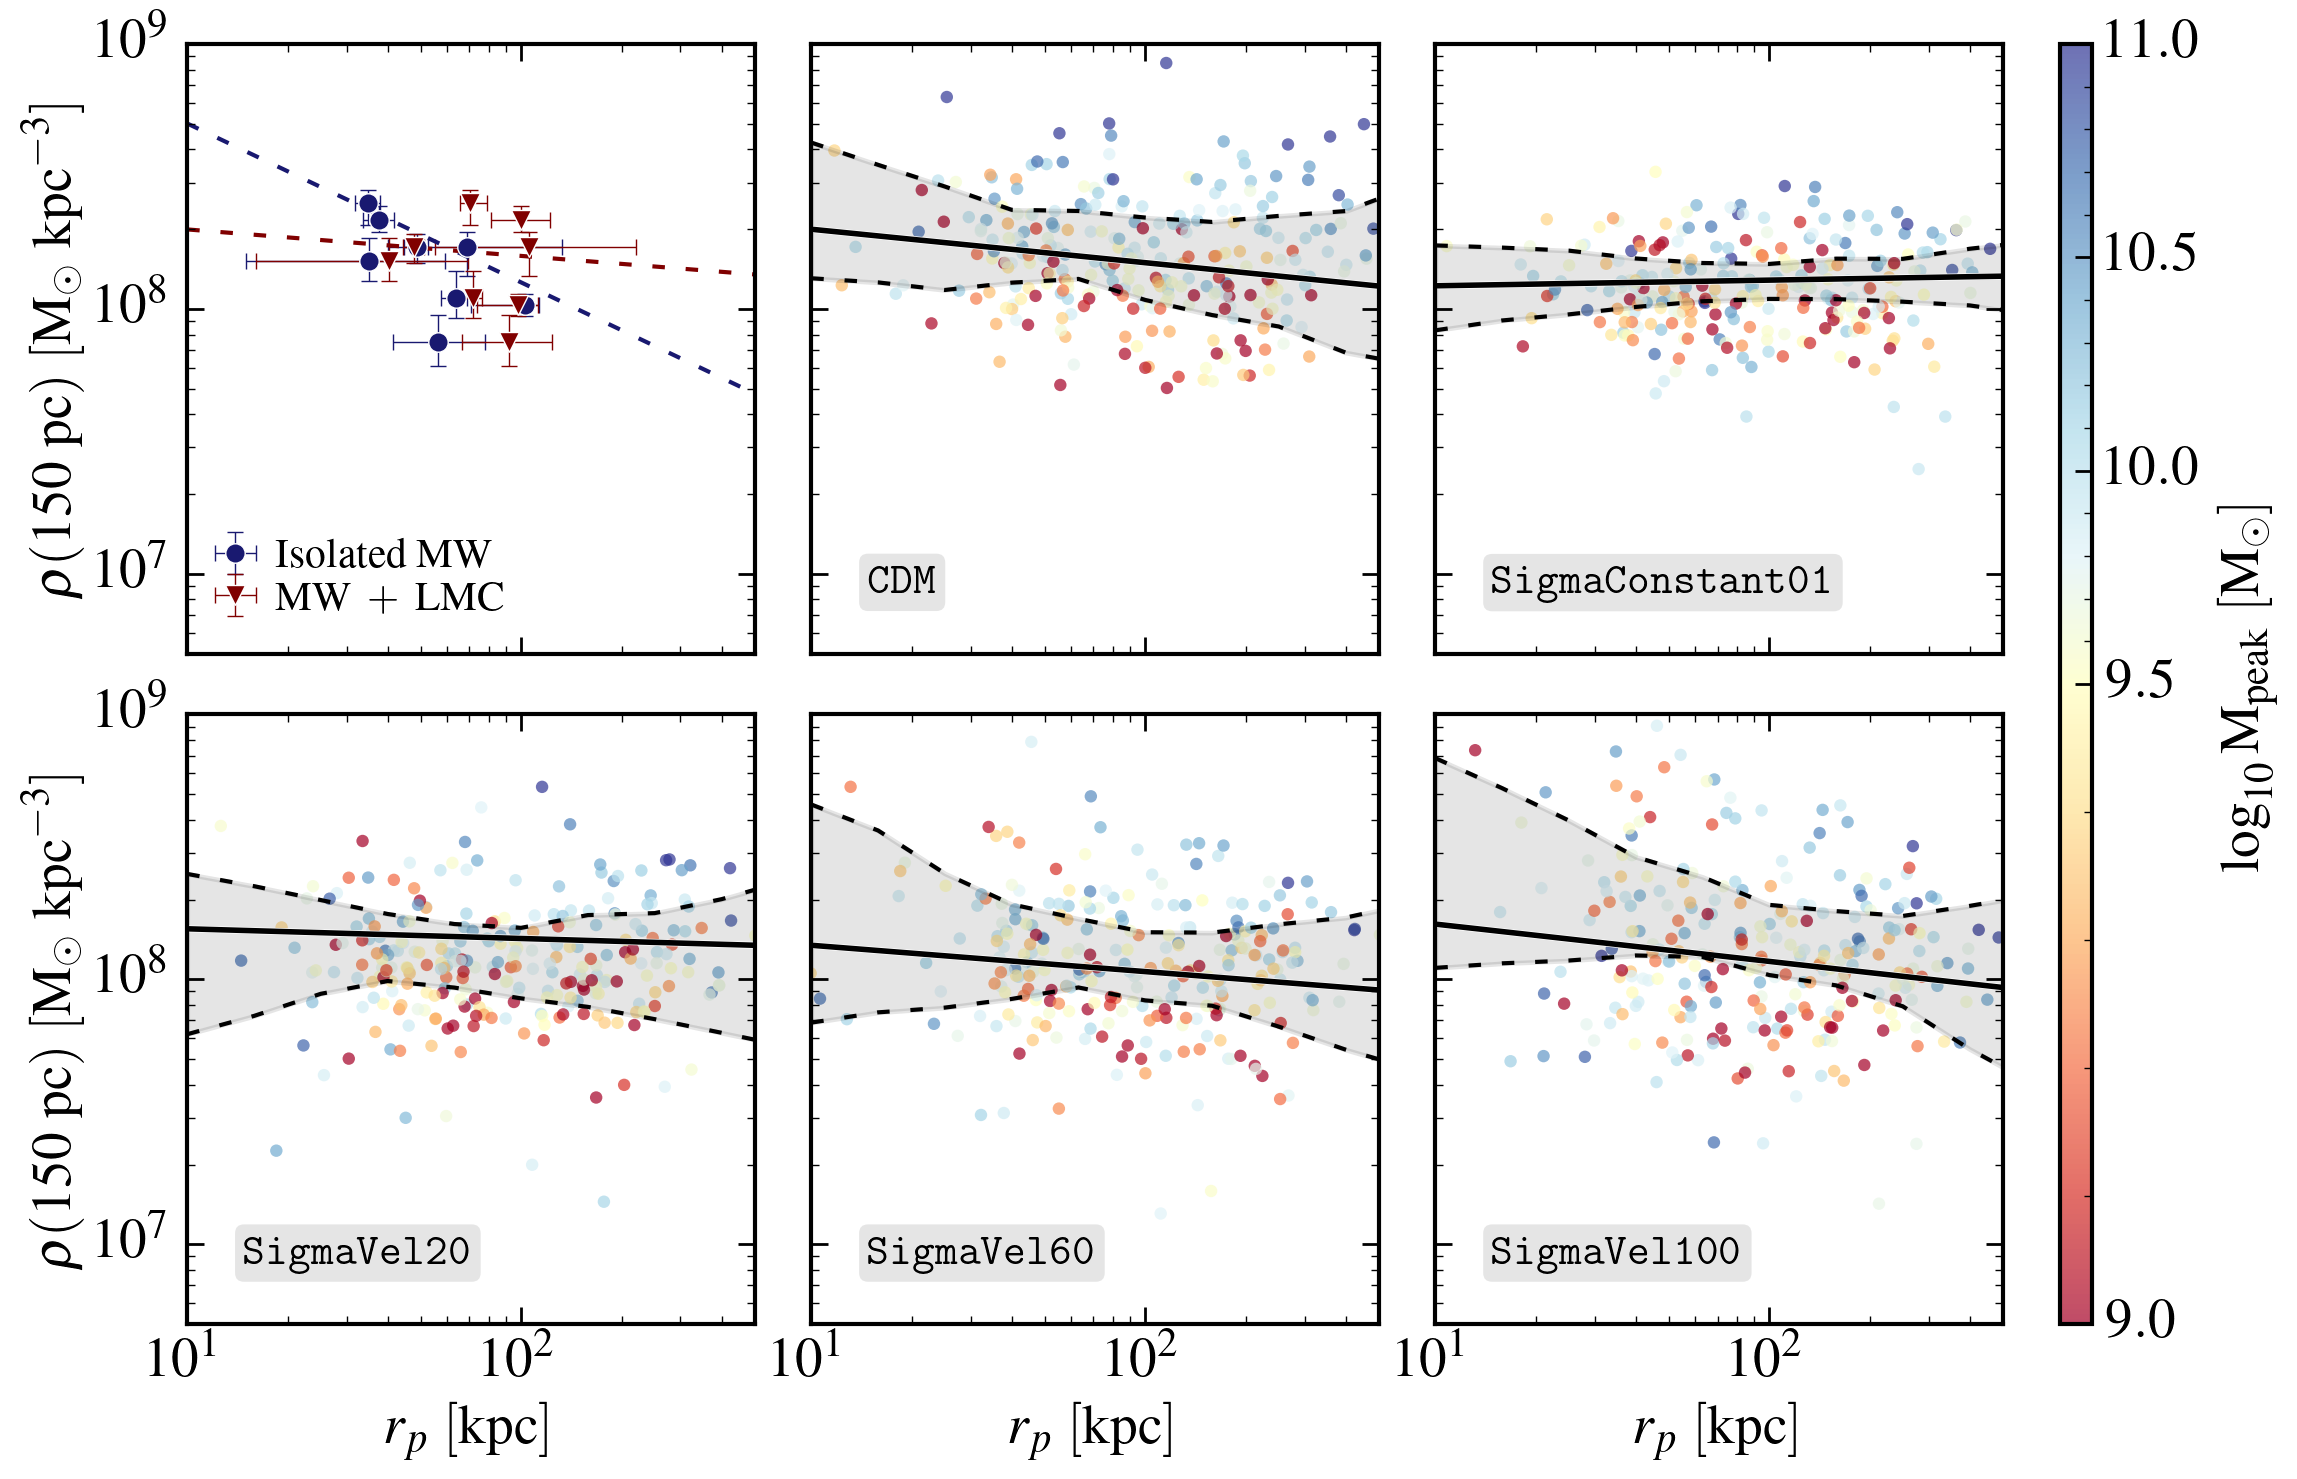

In [12]:
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten() 

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]
        
    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
    
                # sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                # rho = NFW_profile(r_range, rho_s, r_s)
                # mass_within_r = mass(rho, r_range)
                # rho_within_r = rho_mean(mass_within_r, r_range)
                # R200 = calculate_R200(rho_within_r, r_range)
                # _M200 = calculate_M200(R200)
                # M200 = np.append(M200, _M200)
                
                z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]                
                M200 = np.append(M200, mass_peak)

            im = axs.scatter(rp, rho150, c=np.log10(M200), cmap=cmap, marker='o', 
                             lw=0, norm=normalize, alpha=0.7)

            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)
    
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 84)

    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=2., color='black')
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.1, 0.1,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if i==3-1:
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()

####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{peak}}$ $\mathrm{[M_\odot]}$',
                     aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 

####
plt.savefig(f'figures/Density_pericenter_fit_system_mpeak_best_{MAX_SATELLITES}.png',dpi=300, transparent=True)
plt.show()
